### 1. Data Preparation and Exploration (35%)

### 1.1 Creating Spark Session (4%)

### 1.1.1 and 1.1.2
1. Create a SparkConf object for using as many local cores as possible for a proper application name

2. Then create a SparkSession using the SparkConf object.

In [1]:
#1.1.1
import os
# Import libraries needed from pyspark
from pyspark import SparkConf
# Create Spark Configuration Object
master = "local[*]"
app_name = "Assignment-2A"

spark_conf = SparkConf().setMaster(master).setAppName(app_name)
from pyspark.sql import SparkSession # Spark SQL
# Create SparkSession

spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/03 17:12:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/03 17:12:24 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


### 1.2 Loading the Data (16%)

### 1.2.1
1. Load each data file into two separate Spark dataframes. Then print out the row count
and schema of each dataframe.
      
      ○ For the Customer data, please specify the schema before reading the data
into dataframes, and make sure 'BranchID', 'AssetID', 'ManufacturerID', and
'SupplierID' be read as String types. You may find relevant schema
information from the metadata file for the rest of the columns.
    
    ○ For the Bureau data, use PySpark to auto-identify the column types

In [2]:
# 1.2.1

# import OS to get path of the files
import os
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, DoubleType

# loading data
df_bureau = spark.read.format('csv')\
            .option('header',True).option('escape','"')\
            .load(os.getcwd() + "/data/bureau.csv", inferSchema=True)

# custom schema
schema = StructType([ \
    StructField("ID",IntegerType(),True), \
    StructField("Frequency",StringType(),True), \
    StructField("InstlmentMode",StringType(),True), \
    StructField("LoanStatus",StringType(),True), \
    StructField("PaymentMode", StringType(), True), \
    StructField("BranchID", StringType(), True), \
    StructField("Area", StringType(), True), \
    StructField("Tenure",IntegerType(),True), \
    StructField("AssetCost",IntegerType(),True), \
    StructField("AmountFinance",DoubleType(),True), \
    StructField("DisbursalAmount", DoubleType(), True), \
    StructField("EMI", DoubleType(), True), \
    StructField("DisbursalDate", StringType(), True), \
    StructField("MaturityDAte",StringType(),True), \
    StructField("AuthDate",StringType(),True), \
    StructField("AssetID",StringType(),True), \
    #StructField("AssetType",StringType(),True), \
    StructField("ManufacturerID", StringType(), True), \
    StructField("SupplierID", StringType(), True), \
    StructField("LTV", DoubleType(), True), \
    StructField("SEX",StringType(),True), \
    StructField("AGE",IntegerType(),True), \
    StructField("MonthlyIncome",DoubleType(),True), \
    StructField("City", StringType(), True), \
    StructField("State", StringType(), True), \
    StructField("ZiPCODE", IntegerType(), True), \
    StructField("Top-up Month", StringType(), True) \
  ])

# creating df using custom schema
df_customer = spark.read.format('csv')\
            .option('header',True).option('escape','"')\
            .load(os.getcwd() + "/data/customer.csv", schema=schema)

In [3]:
print((df_customer.count(), len(df_customer.columns)))
df_customer.printSchema()


(143400, 26)
root
 |-- ID: integer (nullable = true)
 |-- Frequency: string (nullable = true)
 |-- InstlmentMode: string (nullable = true)
 |-- LoanStatus: string (nullable = true)
 |-- PaymentMode: string (nullable = true)
 |-- BranchID: string (nullable = true)
 |-- Area: string (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- AssetCost: integer (nullable = true)
 |-- AmountFinance: double (nullable = true)
 |-- DisbursalAmount: double (nullable = true)
 |-- EMI: double (nullable = true)
 |-- DisbursalDate: string (nullable = true)
 |-- MaturityDAte: string (nullable = true)
 |-- AuthDate: string (nullable = true)
 |-- AssetID: string (nullable = true)
 |-- ManufacturerID: string (nullable = true)
 |-- SupplierID: string (nullable = true)
 |-- LTV: double (nullable = true)
 |-- SEX: string (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- MonthlyIncome: double (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- ZiPCODE

In [4]:
print((df_bureau.count(), len(df_bureau.columns)))
df_bureau.printSchema()

(624863, 25)
root
 |-- ID: integer (nullable = true)
 |-- SELF-INDICATOR: boolean (nullable = true)
 |-- MATCH-TYPE: string (nullable = true)
 |-- ACCT-TYPE: string (nullable = true)
 |-- CONTRIBUTOR-TYPE: string (nullable = true)
 |-- DATE-REPORTED: timestamp (nullable = true)
 |-- OWNERSHIP-IND: string (nullable = true)
 |-- ACCOUNT-STATUS: string (nullable = true)
 |-- DISBURSED-DT: timestamp (nullable = true)
 |-- CLOSE-DT: timestamp (nullable = true)
 |-- LAST-PAYMENT-DATE: timestamp (nullable = true)
 |-- CREDIT-LIMIT/SANC AMT: string (nullable = true)
 |-- DISBURSED-AMT/HIGH CREDIT: string (nullable = true)
 |-- INSTALLMENT-AMT: string (nullable = true)
 |-- CURRENT-BAL: string (nullable = true)
 |-- INSTALLMENT-FREQUENCY: string (nullable = true)
 |-- OVERDUE-AMT: string (nullable = true)
 |-- WRITE-OFF-AMT: integer (nullable = true)
 |-- ASSET_CLASS: string (nullable = true)
 |-- REPORTED DATE - HIST: string (nullable = true)
 |-- DPD - HIST: string (nullable = true)
 |-- CUR 

### 1.2.2
For the Bureau dataframe, convert all string columns containing ',' to numeric
columns (For example: '50,000' → 50000). For the 'INSTALLMENT-AMT' you also
need to remove the postfix(For example: '1,405/Monthly' -> 1405).

In [5]:
# 1.2.2

from pyspark.sql.functions import col, split
from pyspark.sql.types import IntegerType

from pyspark.sql.functions import regexp_replace

# removing ',' and casting to integer
bureau_converted = df_bureau.withColumn("OVERDUE-AMT", regexp_replace('OVERDUE-AMT', ',', '').cast(IntegerType())) \
                            .withColumn("CURRENT-BAL", regexp_replace('CURRENT-BAL', ',', '').cast(IntegerType())) \
                            .withColumn("DISBURSED-AMT/HIGH CREDIT", regexp_replace('DISBURSED-AMT/HIGH CREDIT', ',', '').cast(IntegerType())) \
                            .withColumn("CREDIT-LIMIT/SANC AMT", regexp_replace('CREDIT-LIMIT/SANC AMT', ',', '').cast(IntegerType())) \
                            .withColumn("INSTALLMENT-AMT", regexp_replace('INSTALLMENT-AMT', ',', '')) \
                            .withColumn("INSTALLMENT-AMT", split(col("INSTALLMENT-AMT"), "/").getItem(0).cast(IntegerType()))
                                        

bureau_converted.select("OVERDUE-AMT", "CURRENT-BAL","DISBURSED-AMT/HIGH CREDIT", "CREDIT-LIMIT/SANC AMT","INSTALLMENT-AMT").toPandas().head()






,OVERDUE-AMT,CURRENT-BAL,DISBURSED-AMT/HIGH CREDIT,CREDIT-LIMIT/SANC AMT,INSTALLMENT-AMT
0,NaN,20797.0,44000.0,NaN,1405.0
1,37873.0,37873.0,37352.0,NaN,NaN
2,0.0,0.0,400000.0,NaN,NaN
3,0.0,0.0,500000.0,NaN,NaN
4,0.0,116087.0,145000.0,NaN,NaN


In [6]:
bureau_converted.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- SELF-INDICATOR: boolean (nullable = true)
 |-- MATCH-TYPE: string (nullable = true)
 |-- ACCT-TYPE: string (nullable = true)
 |-- CONTRIBUTOR-TYPE: string (nullable = true)
 |-- DATE-REPORTED: timestamp (nullable = true)
 |-- OWNERSHIP-IND: string (nullable = true)
 |-- ACCOUNT-STATUS: string (nullable = true)
 |-- DISBURSED-DT: timestamp (nullable = true)
 |-- CLOSE-DT: timestamp (nullable = true)
 |-- LAST-PAYMENT-DATE: timestamp (nullable = true)
 |-- CREDIT-LIMIT/SANC AMT: integer (nullable = true)
 |-- DISBURSED-AMT/HIGH CREDIT: integer (nullable = true)
 |-- INSTALLMENT-AMT: integer (nullable = true)
 |-- CURRENT-BAL: integer (nullable = true)
 |-- INSTALLMENT-FREQUENCY: string (nullable = true)
 |-- OVERDUE-AMT: integer (nullable = true)
 |-- WRITE-OFF-AMT: integer (nullable = true)
 |-- ASSET_CLASS: string (nullable = true)
 |-- REPORTED DATE - HIST: string (nullable = true)
 |-- DPD - HIST: string (nullable = true)
 |-- CUR BAL - HI

### 1.2.3
Show how many rows contain a null value in the Customer dataframe, and remove
all rows which contain any null value.

In [7]:
# 1.2.3

from pyspark.sql.functions import isnan, when, count, col

# removing null and NAN values
df_customer.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_customer.columns]).show()


22/10/03 17:12:40 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+---------+-------------+----------+-----------+--------+-----+------+---------+-------------+---------------+---+-------------+------------+--------+-------+--------------+----------+---+---+---+-------------+-----+-----+-------+------------+
| ID|Frequency|InstlmentMode|LoanStatus|PaymentMode|BranchID| Area|Tenure|AssetCost|AmountFinance|DisbursalAmount|EMI|DisbursalDate|MaturityDAte|AuthDate|AssetID|ManufacturerID|SupplierID|LTV|SEX|AGE|MonthlyIncome| City|State|ZiPCODE|Top-up Month|
+---+---------+-------------+----------+-----------+--------+-----+------+---------+-------------+---------------+---+-------------+------------+--------+-------+--------------+----------+---+---+---+-------------+-----+-----+-------+------------+
|  0|        0|            0|         0|          0|       0|12199|     0|        0|            0|              0|  0|            0|           1|       0|      0|             2|         0|  0| 64| 66|          248|11256|    0|    373|           0|
+---+---

In [8]:
print(f"Total count of rows with null values {df_customer.subtract(df_customer.dropna()).count()}")







Total count of rows with null values 22092


In [9]:
# removing null values from rows and reoving from the table
df_customer = df_customer.na.drop(how="any")

In [10]:
df_customer.count()

121308

In [11]:
bureau_converted.count()

624863

In [12]:
from pyspark.sql.functions import isnan, when, count, col
bureau_converted.select([count(when(col(c).isNull(), c)).alias(c) for c in bureau_converted.columns]).show()





+---+--------------+----------+---------+----------------+-------------+-------------+--------------+------------+--------+-----------------+---------------------+-------------------------+---------------+-----------+---------------------+-----------+-------------+-----------+--------------------+----------+--------------+------------------+---------------+------+
| ID|SELF-INDICATOR|MATCH-TYPE|ACCT-TYPE|CONTRIBUTOR-TYPE|DATE-REPORTED|OWNERSHIP-IND|ACCOUNT-STATUS|DISBURSED-DT|CLOSE-DT|LAST-PAYMENT-DATE|CREDIT-LIMIT/SANC AMT|DISBURSED-AMT/HIGH CREDIT|INSTALLMENT-AMT|CURRENT-BAL|INSTALLMENT-FREQUENCY|OVERDUE-AMT|WRITE-OFF-AMT|ASSET_CLASS|REPORTED DATE - HIST|DPD - HIST|CUR BAL - HIST|AMT OVERDUE - HIST|AMT PAID - HIST|TENURE|
+---+--------------+----------+---------+----------------+-------------+-------------+--------------+------------+--------+-----------------+---------------------+-------------------------+---------------+-----------+---------------------+-----------+-------------+-

### 1.2.4
Show the null percentage of all columns in the Bureau dataframe, and drop the
columns whose percentage of null is larger than 20% since those columns might
have less influence on our accuracy.

In [13]:
# 1.2.4

from pyspark.sql.functions import *

# finding values more than 20 and dropping it from the table
count_val = bureau_converted.count()
df_bureau_percentage = bureau_converted.select([(count(when(col(c).isNull(), c)) * 100/ count_val).alias(c) for c in bureau_converted.columns])
for column in df_bureau_percentage.columns:
    if df_bureau_percentage[[column]].first()[column] > 20:
        bureau_converted = bureau_converted.drop(column)
df_bureau_percentage.toPandas().head()


,ID,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,DATE-REPORTED,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-DT,CLOSE-DT,...,INSTALLMENT-FREQUENCY,OVERDUE-AMT,WRITE-OFF-AMT,ASSET_CLASS,REPORTED DATE - HIST,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,TENURE
0,0.0,0.0,0.0,0.0,0.0,0.589409,0.0,0.0,5.152169,45.323695,...,75.757086,21.127511,3.470201,53.656241,3.470201,3.554699,3.470201,3.470201,3.675366,65.772657


In [14]:
bureau_converted.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- SELF-INDICATOR: boolean (nullable = true)
 |-- MATCH-TYPE: string (nullable = true)
 |-- ACCT-TYPE: string (nullable = true)
 |-- CONTRIBUTOR-TYPE: string (nullable = true)
 |-- DATE-REPORTED: timestamp (nullable = true)
 |-- OWNERSHIP-IND: string (nullable = true)
 |-- ACCOUNT-STATUS: string (nullable = true)
 |-- DISBURSED-DT: timestamp (nullable = true)
 |-- DISBURSED-AMT/HIGH CREDIT: integer (nullable = true)
 |-- CURRENT-BAL: integer (nullable = true)
 |-- WRITE-OFF-AMT: integer (nullable = true)
 |-- REPORTED DATE - HIST: string (nullable = true)
 |-- DPD - HIST: string (nullable = true)
 |-- CUR BAL - HIST: string (nullable = true)
 |-- AMT OVERDUE - HIST: string (nullable = true)
 |-- AMT PAID - HIST: string (nullable = true)



### 1.2.5
Remove all columns containing 'HIST’ in the columns’ names for the bureau
dataframe and all columns related to ‘time’ (the columns’ names contained “DATE” or
“DT”) in the bureau dataframe, as they are hard to be merged in the following
process.

In [15]:
# 1.2.5

# removing values with date,  HIST, DT
for column in bureau_converted.columns:
    if "HIST" in column or "DT" in column or "DATE" in column:
        bureau_converted = bureau_converted.drop(column)
bureau_converted.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- SELF-INDICATOR: boolean (nullable = true)
 |-- MATCH-TYPE: string (nullable = true)
 |-- ACCT-TYPE: string (nullable = true)
 |-- CONTRIBUTOR-TYPE: string (nullable = true)
 |-- OWNERSHIP-IND: string (nullable = true)
 |-- ACCOUNT-STATUS: string (nullable = true)
 |-- DISBURSED-AMT/HIGH CREDIT: integer (nullable = true)
 |-- CURRENT-BAL: integer (nullable = true)
 |-- WRITE-OFF-AMT: integer (nullable = true)



### 1.3 Exploring the data (15%)

### 1.3.1 
For each numeric feature in each activity, show the basic statistics (including count,
mean, std dev, min, max); for each non-numeric feature in each activity, display the
top-10 values and the corresponding counts.
○ No need to show the “Top-up Month” and “ID” columns

In [16]:
# 1.3.1

df_customer.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Frequency: string (nullable = true)
 |-- InstlmentMode: string (nullable = true)
 |-- LoanStatus: string (nullable = true)
 |-- PaymentMode: string (nullable = true)
 |-- BranchID: string (nullable = true)
 |-- Area: string (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- AssetCost: integer (nullable = true)
 |-- AmountFinance: double (nullable = true)
 |-- DisbursalAmount: double (nullable = true)
 |-- EMI: double (nullable = true)
 |-- DisbursalDate: string (nullable = true)
 |-- MaturityDAte: string (nullable = true)
 |-- AuthDate: string (nullable = true)
 |-- AssetID: string (nullable = true)
 |-- ManufacturerID: string (nullable = true)
 |-- SupplierID: string (nullable = true)
 |-- LTV: double (nullable = true)
 |-- SEX: string (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- MonthlyIncome: double (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- ZiPCODE: integer (nu

In [17]:
from pyspark.sql.types import StringType

# getting list of string columns
str_cols = [f.name for f in df_customer.schema.fields if isinstance(f.dataType, StringType)]

# finding the count of non numeric columns
for colm in str_cols:
    df_customer.groupBy(colm).count().sort(colm, ascending=True).show(10)
    


+-----------+-----+
|  Frequency|count|
+-----------+-----+
| BI-Monthly|  305|
|Half Yearly|78986|
|    Monthly|22535|
|    Quatrly|19482|
+-----------+-----+

+-------------+------+
|InstlmentMode| count|
+-------------+------+
|      Advance|  4309|
|       Arrear|116999|
+-------------+------+

+----------+-----+
|LoanStatus|count|
+----------+-----+
|    Active|35048|
|    Closed|86260|
+----------+-----+

+------------+-----+
| PaymentMode|count|
+------------+-----+
|  Auto Debit|  905|
|      Billed|17668|
|      Cheque|  489|
|Direct Debit|32545|
|         ECS|33078|
|  ECS Reject|  457|
|      Escrow|    7|
|         PDC|25951|
|  PDC Reject|    7|
|       PDC_E| 9398|
+------------+-----+
only showing top 10 rows

+--------+-----+
|BranchID|count|
+--------+-----+
|     106|  616|
|      11|   10|
|     110|  743|
|     116|  383|
|      12|    1|
|     120|   82|
|     124|  385|
|     125|  554|
|     130|  381|
|     131|  453|
+--------+-----+
only showing top 10 rows

+

+-------------------+-----+
|      DisbursalDate|count|
+-------------------+-----+
|2010-02-09 00:00:00|    2|
|2010-02-10 00:00:00|    5|
|2010-02-11 00:00:00|    2|
|2010-02-16 00:00:00|    3|
|2010-02-19 00:00:00|    1|
|2010-02-22 00:00:00|    2|
|2010-02-23 00:00:00|    5|
|2010-02-24 00:00:00|    4|
|2010-02-25 00:00:00|    1|
|2010-02-26 00:00:00|   10|
+-------------------+-----+
only showing top 10 rows

+-------------------+-----+
|       MaturityDAte|count|
+-------------------+-----+
|2011-03-18 00:00:00|    1|
|2011-07-10 00:00:00|    1|
|2011-09-05 00:00:00|    1|
|2011-10-05 00:00:00|    1|
|2011-10-15 00:00:00|    2|
|2011-11-05 00:00:00|    1|
|2011-12-10 00:00:00|    1|
|2012-01-01 00:00:00|    3|
|2012-01-10 00:00:00|    1|
|2012-01-20 00:00:00|    1|
+-------------------+-----+
only showing top 10 rows

+-------------------+-----+
|           AuthDate|count|
+-------------------+-----+
|2010-02-09 00:00:00|    2|
|2010-02-10 00:00:00|    5|
|2010-02-11 00:00:00|   

In [18]:
df_stat = df_customer.select("Tenure", "AssetCost", "AmountFinance","DisbursalAmount", "EMI", \
                            "LTV", "AGE", "MonthlyIncome","ZiPCODE")

# summary of data frame
df_stat.describe().toPandas().head()



,summary,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,LTV,AGE,MonthlyIncome,ZiPCODE
0,count,121308,121308,121308,121308,121308,121308,121308,121308,121308
1,mean,42.75597652257065,563289.852482936,356361.52626380784,356002.3838225838,56821.715147310984,59.62412924127014,40.70355623701652,51901.61362465795,421356.78347676987
2,stddev,22.433473986085684,103558.845010007,105717.74807158229,105537.25852397807,28585.22968535343,15.818416557893899,11.794657218312995,1774582.5522165208,170779.11249764307
3,min,5,200000,50000.0,2894.0,200.0,-1.38,18,0.0,110000
4,max,501,2250000,1308351.0,1308351.0,460000.0,100.0,90,6.174775E8,855456


In [19]:
bureau_converted.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- SELF-INDICATOR: boolean (nullable = true)
 |-- MATCH-TYPE: string (nullable = true)
 |-- ACCT-TYPE: string (nullable = true)
 |-- CONTRIBUTOR-TYPE: string (nullable = true)
 |-- OWNERSHIP-IND: string (nullable = true)
 |-- ACCOUNT-STATUS: string (nullable = true)
 |-- DISBURSED-AMT/HIGH CREDIT: integer (nullable = true)
 |-- CURRENT-BAL: integer (nullable = true)
 |-- WRITE-OFF-AMT: integer (nullable = true)



In [20]:
df_stat_bureau = bureau_converted.select("DISBURSED-AMT/HIGH CREDIT", "CURRENT-BAL", "WRITE-OFF-AMT")

# summary of dataframe
df_stat_bureau.describe().toPandas().head()

,summary,DISBURSED-AMT/HIGH CREDIT,CURRENT-BAL,WRITE-OFF-AMT
0,count,624825,624598,603179
1,mean,316589.3861433201,103717.07101207497,291.3442643062839
2,stddev,5176936.446701577,851087.5975786744,19561.752315897807
3,min,-83878,-20868956,-30
4,max,999999999,375991329,8797356


In [21]:
# getting list of string columns
str_cols_br = [f.name for f in bureau_converted.schema.fields if isinstance(f.dataType, StringType)]

# finding the count of non numeric columns
for colm in str_cols_br:
    bureau_converted.groupBy(colm).count().sort(colm, ascending=True).show(10)



+----------+------+
|MATCH-TYPE| count|
+----------+------+
|   PRIMARY|624638|
| SECONDARY|   225|
+----------+------+

+--------------------+-----+
|           ACCT-TYPE|count|
+--------------------+-----+
|Auto Loan (Personal)|33504|
|Business Loan - S...|  375|
|Business Loan Aga...|  332|
|Business Loan Gen...| 4464|
|Business Loan Pri...|88274|
|Business Loan Pri...| 1223|
|Business Loan Pri...| 2159|
|Business Loan Uns...|  249|
|Business Non-Fund...|   77|
|Business Non-Fund...|  132|
+--------------------+-----+
only showing top 10 rows

+----------------+------+
|CONTRIBUTOR-TYPE| count|
+----------------+------+
|             ARC|     8|
|             CCC|  1651|
|             COP| 26853|
|             FRB|   813|
|             HFC|  3174|
|             MFI|  3676|
|             NAB|191368|
|             NBF|286311|
|             OFI|     4|
|             PRB| 84392|
+----------------+------+
only showing top 10 rows

+----------------+------+
|   OWNERSHIP-IND| count|
+----

### 1.3.2 
Merged rows in the Bureau dataframe by 'ID’. To achieve this question, sum the rows
for numeric type columns, count distinct values for other columns with other data
types, and rename them with the postfix like '_sum' or '_dist'. (For example, we did
the sum function based on the 'HIGH CREDIT', and the new column’s name will be
'HIGH CREDIT_sum').
○ Sum/distinct is just a simple way to merge the rows, after merging, they may
lose some information, but it is an easy way to combine information together.
And also helps us to reduce the size of the module.


In [22]:
bureau_converted.printSchema()


root
 |-- ID: integer (nullable = true)
 |-- SELF-INDICATOR: boolean (nullable = true)
 |-- MATCH-TYPE: string (nullable = true)
 |-- ACCT-TYPE: string (nullable = true)
 |-- CONTRIBUTOR-TYPE: string (nullable = true)
 |-- OWNERSHIP-IND: string (nullable = true)
 |-- ACCOUNT-STATUS: string (nullable = true)
 |-- DISBURSED-AMT/HIGH CREDIT: integer (nullable = true)
 |-- CURRENT-BAL: integer (nullable = true)
 |-- WRITE-OFF-AMT: integer (nullable = true)



In [23]:
import pyspark.sql.functions as func

# merging rows with ID
df_agg = bureau_converted.groupby("ID").\
    agg(
        func.countDistinct("SELF-INDICATOR").alias("SELF-INDICATOR_dist"),
        func.countDistinct("MATCH-TYPE").alias("MATCH-TYPE_dist"),
        func.countDistinct("ACCT-TYPE").alias("ACCT-TYPE_dist"),
        func.countDistinct("CONTRIBUTOR-TYPE").alias("CONTRIBUTOR-TYPE_dist"),
        func.countDistinct("OWNERSHIP-IND").alias("OWNERSHIP-IND_dist"),
        func.countDistinct("ACCOUNT-STATUS").alias("ACCOUNT-STATUS_dist"),
        func.sum("DISBURSED-AMT/HIGH CREDIT").alias("DISBURSED-AMT/HIGH CREDIT_sum"),
        func.sum("CURRENT-BAL").alias("CURRENT-BAL_sum"),
        func.sum("WRITE-OFF-AMT").alias("WRITE-OFF-AMT_sum")
    )
df_agg.sort("ID", ascending=True).toPandas().head(10)

,ID,SELF-INDICATOR_dist,MATCH-TYPE_dist,ACCT-TYPE_dist,CONTRIBUTOR-TYPE_dist,OWNERSHIP-IND_dist,ACCOUNT-STATUS_dist,DISBURSED-AMT/HIGH CREDIT_sum,CURRENT-BAL_sum,WRITE-OFF-AMT_sum
0,1,2,1,4,2,1,3,2201352,618526,0
1,2,2,1,7,2,2,2,18117081,10349457,0
2,3,2,1,8,5,3,3,3708369,2065165,0
3,4,2,1,4,3,2,2,2964588,2191274,0
4,5,2,1,5,4,2,2,1939813,907231,0
5,6,2,1,4,2,3,2,3237361,102800,0
6,7,2,1,2,1,1,2,1272553,624000,0
7,8,2,1,3,3,3,4,2025216,974119,0
8,9,1,1,1,1,1,1,280000,0,0
9,10,2,1,2,1,2,2,1164268,283723,0


In [24]:
df_agg.count()

143400

In [25]:
df_agg.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- SELF-INDICATOR_dist: long (nullable = false)
 |-- MATCH-TYPE_dist: long (nullable = false)
 |-- ACCT-TYPE_dist: long (nullable = false)
 |-- CONTRIBUTOR-TYPE_dist: long (nullable = false)
 |-- OWNERSHIP-IND_dist: long (nullable = false)
 |-- ACCOUNT-STATUS_dist: long (nullable = false)
 |-- DISBURSED-AMT/HIGH CREDIT_sum: long (nullable = true)
 |-- CURRENT-BAL_sum: long (nullable = true)
 |-- WRITE-OFF-AMT_sum: long (nullable = true)



In [26]:
df_customer.count()

121308

### 1.3.3
Join the two dataframe with 'ID' by using inner join, then replace the 'Top-up Month'
column with a new 'Top-up' column which uses 0 to indicate this customer has 'No
Top-up Service' in the 'Top-up Month' column and uses 1 to indicate customer has
any type of ‘Top-up Services’ except ‘No Top-up Service’

In [27]:
# joining two tables to calculate percentage
from pyspark.sql.functions import when


# joining with ID

df_inner_join = df_agg.join(df_customer, on = 'ID',how='inner').withColumnRenamed("Top-up Month","Top-up")

# assinging 0 and 1 to top-up values
df_inner_update = df_inner_join.withColumn("Top-up", when(df_inner_join["Top-up"] == "No Top-up Service",0).otherwise(1))

df_inner_update.toPandas().head(10)



,ID,SELF-INDICATOR_dist,MATCH-TYPE_dist,ACCT-TYPE_dist,CONTRIBUTOR-TYPE_dist,OWNERSHIP-IND_dist,ACCOUNT-STATUS_dist,DISBURSED-AMT/HIGH CREDIT_sum,CURRENT-BAL_sum,WRITE-OFF-AMT_sum,...,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,Top-up
0,26,2,1,5,3,2,3,6172575,193985,0,...,1187,24275,64.00,M,35,116574.58,RAIPUR,CHATTISGARH,493889,0
1,78,2,1,4,3,1,2,3570486,552973,0,...,1046,20641,67.18,M,34,12835.00,JAGATSINGHAPUR,ORISSA,754141,0
2,81,1,1,1,1,1,1,320000,0,0,...,1062,23546,66.11,M,37,6666.67,CUTTACK,ORISSA,754004,0
3,85,1,1,1,1,1,1,605000,0,0,...,1046,24113,71.13,M,49,40000.00,PURI,ORISSA,752110,0
4,101,2,1,2,2,1,2,388000,0,0,...,1046,24113,52.93,M,58,27500.00,PURI,ORISSA,752104,0
5,108,2,1,5,2,2,3,9903535,3316549,0,...,1046,28550,54.50,M,31,18333.33,NABARANGAPUR,ORISSA,764059,0
6,115,2,1,3,3,1,2,1240590,653653,0,...,1046,28550,72.98,M,42,21579.00,NABARANGAPUR,ORISSA,764075,1
7,126,2,1,2,3,2,2,518940,7135,0,...,1046,73027,57.34,F,49,41666.67,JAJAPUR,ORISSA,755045,1
8,133,2,1,2,2,1,2,454200,31931,0,...,1187,23830,79.02,M,26,52500.00,KORAPUT,ORISSA,764037,0
9,137,1,1,1,1,1,1,440000,0,0,...,1046,24113,78.43,M,55,20833.33,PURI,ORISSA,752108,0


In [28]:
df_inner_update.count()

121308

In [29]:
df_inner_join.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- SELF-INDICATOR_dist: long (nullable = false)
 |-- MATCH-TYPE_dist: long (nullable = false)
 |-- ACCT-TYPE_dist: long (nullable = false)
 |-- CONTRIBUTOR-TYPE_dist: long (nullable = false)
 |-- OWNERSHIP-IND_dist: long (nullable = false)
 |-- ACCOUNT-STATUS_dist: long (nullable = false)
 |-- DISBURSED-AMT/HIGH CREDIT_sum: long (nullable = true)
 |-- CURRENT-BAL_sum: long (nullable = true)
 |-- WRITE-OFF-AMT_sum: long (nullable = true)
 |-- Frequency: string (nullable = true)
 |-- InstlmentMode: string (nullable = true)
 |-- LoanStatus: string (nullable = true)
 |-- PaymentMode: string (nullable = true)
 |-- BranchID: string (nullable = true)
 |-- Area: string (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- AssetCost: integer (nullable = true)
 |-- AmountFinance: double (nullable = true)
 |-- DisbursalAmount: double (nullable = true)
 |-- EMI: double (nullable = true)
 |-- DisbursalDate: string (nullable = true)
 |-- MaturityDAte

### 1.3.4
For each bureau and customer data, present two plots worthy of presenting to the MonPG company, describe your plots and discuss the findings from the plots
    
    ○ Hint - 1: you can use the basic plots (e.g. histograms, line charts, scatter plots) for the relationship between a column and the “Top-up” label (such as “city” and “Top-up”, “age” and “Top-up”); or more advanced plots like correlation plots for the relationship between each column; 2: if your data is too large for the plotting, consider using sampling before plotting
    
    ○ 100 words max for each plot’s description and discussion

In [30]:
pandasDF = df_inner_update.toPandas()
print(pandasDF)
pear_corr=pandasDF.corr(method='pearson')
pear_corr

            ID  SELF-INDICATOR_dist  MATCH-TYPE_dist  ACCT-TYPE_dist  \
0           26                    2                1               5   
1           78                    2                1               4   
2           81                    1                1               1   
3           85                    1                1               1   
4          101                    2                1               2   
...        ...                  ...              ...             ...   
121303  143290                    1                1               1   
121304  143332                    1                1               1   
121305  143333                    2                1               4   
121306  143349                    1                1               1   
121307  143363                    1                1               1   

        CONTRIBUTOR-TYPE_dist  OWNERSHIP-IND_dist  ACCOUNT-STATUS_dist  \
0                           3                   2            

/var/folders/cf/pqgc9fqs79z8hp6792n3_hgm0000gn/T/ipykernel_55340/628810357.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pear_corr=pandasDF.corr(method='pearson')


,ID,SELF-INDICATOR_dist,MATCH-TYPE_dist,ACCT-TYPE_dist,CONTRIBUTOR-TYPE_dist,OWNERSHIP-IND_dist,ACCOUNT-STATUS_dist,DISBURSED-AMT/HIGH CREDIT_sum,CURRENT-BAL_sum,WRITE-OFF-AMT_sum,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,LTV,AGE,MonthlyIncome,ZiPCODE,Top-up
ID,1.000000,-0.043397,-0.009261,-0.092703,-0.081571,-0.072767,-0.085473,-0.017953,-0.018477,-0.006908,-0.036345,0.029422,0.053481,0.053473,-0.006573,0.043998,-0.049878,0.005267,-0.098008,0.032031
SELF-INDICATOR_dist,-0.043397,1.000000,-0.020459,0.629410,0.682373,0.413520,0.665333,0.063101,0.106878,0.025385,0.006725,0.024179,0.059972,0.060887,0.087947,0.050607,0.036511,-0.001943,-0.007425,0.159396
MATCH-TYPE_dist,-0.009261,-0.020459,1.000000,0.009546,0.009376,0.010851,0.010656,-0.000809,0.000178,0.003365,0.000567,0.006096,0.005151,0.005228,0.001866,0.003929,0.001027,0.000039,0.009932,0.005231
ACCT-TYPE_dist,-0.092703,0.629410,0.009546,1.000000,0.768850,0.522682,0.674967,0.128217,0.229905,0.041714,-0.001628,0.050559,0.086424,0.087257,0.095865,0.065419,0.023083,0.000155,0.029761,0.211339
CONTRIBUTOR-TYPE_dist,-0.081571,0.682373,0.009376,0.768850,1.000000,0.434710,0.641812,0.098694,0.167768,0.035398,0.005030,0.041359,0.072321,0.073308,0.105915,0.053526,0.065091,-0.000502,0.028316,0.180860
OWNERSHIP-IND_dist,-0.072767,0.413520,0.010851,0.522682,0.434710,1.000000,0.450686,0.101063,0.174485,0.035914,0.001356,0.028828,0.063053,0.063639,0.067766,0.054951,0.005084,-0.000382,0.004440,0.104364
ACCOUNT-STATUS_dist,-0.085473,0.665333,0.010656,0.674967,0.641812,0.450686,1.000000,0.080264,0.149475,0.068387,0.014127,0.034035,0.074904,0.075595,0.089481,0.063183,0.032826,-0.001282,0.026847,0.165509
DISBURSED-AMT/HIGH CREDIT_sum,-0.017953,0.063101,-0.000809,0.128217,0.098694,0.101063,0.080264,1.000000,0.364187,0.010358,-0.004670,0.005325,0.014045,0.014187,0.011677,0.013343,0.008232,0.000242,-0.003350,0.016509
CURRENT-BAL_sum,-0.018477,0.106878,0.000178,0.229905,0.167768,0.174485,0.149475,0.364187,1.000000,0.011282,-0.003214,0.016899,0.032128,0.032224,0.014686,0.025827,0.004143,0.000735,-0.012664,0.040675
WRITE-OFF-AMT_sum,-0.006908,0.025385,0.003365,0.041714,0.035398,0.035914,0.068387,0.010358,0.011282,1.000000,0.007225,-0.001707,0.007530,0.007619,0.004319,0.008591,0.009010,-0.000041,-0.003108,-0.000958


### Feature extraction and ML training (55%)

/var/folders/cf/pqgc9fqs79z8hp6792n3_hgm0000gn/T/ipykernel_55340/3841986571.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(pandasDF.columns, rotation=65, fontsize=15)
/var/folders/cf/pqgc9fqs79z8hp6792n3_hgm0000gn/T/ipykernel_55340/3841986571.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(pandasDF.columns, rotation=0, fontsize=15)


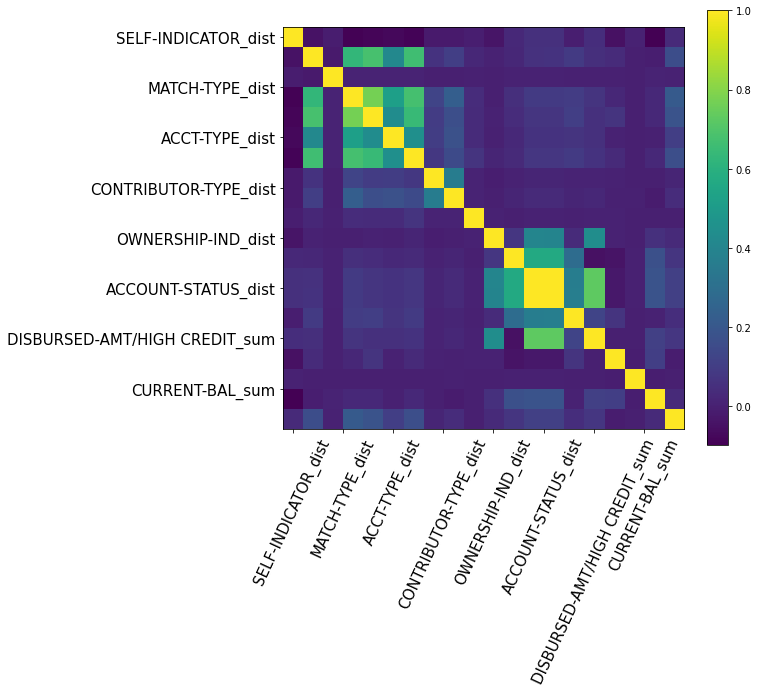

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(pear_corr, interpolation='nearest')
fig.colorbar(im, orientation='vertical', fraction = 0.05)

# Show all ticks and label them with the dataframe column name
ax.set_xticklabels(pandasDF.columns, rotation=65, fontsize=15)
ax.set_yticklabels(pandasDF.columns, rotation=0, fontsize=15)



plt.show()

This correlation plot is describing how the fields are correlated with other columns. It helps in determing the which columns are related to each other and strength of this relationship. From this we can say tha self-indicator _dist and others have positive correlation whereas those which are missing have negative correlation, which means they are not related


### CUSTOMER DATA

In [32]:
with_topup = df_inner_update.filter(df_inner_update["Top-up"] == 1).groupBy("SEX").count()

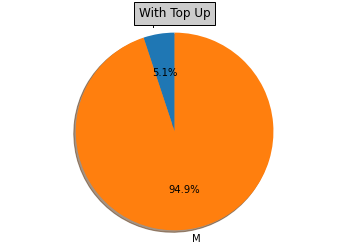

In [33]:
import matplotlib.pyplot as plt

panda_df = with_topup.toPandas()
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = panda_df.SEX
sizes = panda_df["count"]

fig1, ax1 = plt.subplots()
ax1.pie(sizes,  labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("With Top Up", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

The above pie chart tells how SEX ( M or F) are dependent as we can see the majority of people in the dataset are male. This is categorical data where the value can be M or F only.

In [34]:
with_topup_freq = df_inner_update.filter(df_inner_update["Top-up"] == 1).groupBy("Frequency").count()

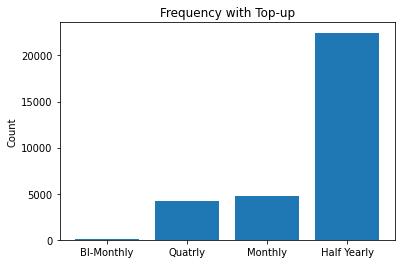

In [35]:
import matplotlib.pyplot as plt

panda_df = with_topup_freq.toPandas()
fig, ax = plt.subplots()

city = panda_df.Frequency
count = panda_df["count"]

ax.bar(city, count)

ax.set_ylabel('Count')
ax.set_title('Frequency with Top-up')


plt.show()

The above BAR chart tells about the Frequency and its count. From the graph we can conclude that he People have very less Bi-Monthly Frequecny wheras the majority of the people have opted for Half-yearly

In [36]:
with_topup_state = df_inner_update.filter(df_inner_update["Top-up"] == 1).groupBy("State").count()

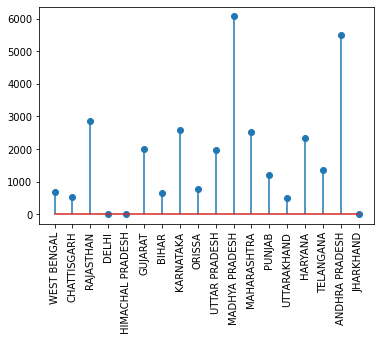

In [37]:
import matplotlib.pyplot as plt

panda_df = with_topup_state.toPandas()
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = panda_df["State"]
sizes = panda_df["count"]

import matplotlib.pyplot as plt
import numpy as np

x = panda_df["State"]
y = panda_df["count"]
plt.xticks(rotation = 90)
plt.stem(x, y)
plt.show()

The above graph is Stem graph which is used to describe how many states have Top-up values. From the graph we can say that Madhaya pradesh has more number of Top-ups the data are with some outliers as we can see the count is zero for some states

In [38]:
with_topup_loan = df_inner_update.filter(df_inner_update["Top-up"] == 1).groupBy("LoanStatus").count()

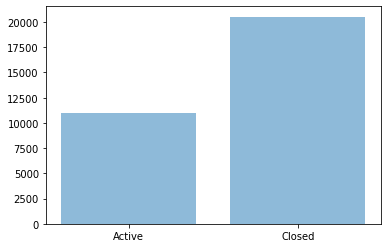

In [39]:
import numpy as np
import matplotlib.pyplot as plt
panda_df = with_topup_loan.toPandas()


N = 50
x = panda_df["LoanStatus"]
y = panda_df["count"]
ax.set_title('Loan Status with Top-up')

plt.bar(x, y, alpha=0.5)
plt.show()

The above bar graph is about the loan status where people have opted for top up. There are more closed loan status then active. it is almost half.

#### 2.1.1 Preparing the training data and testing data (4%)

Randomly split the dataset into 80% training data and 20% testing data for each use
case

In [40]:
# dividing the data set to training and test dataset
trainDF, testDF = df_inner_update.randomSplit([.8, .2], seed = 42)
print(f"""There are {trainDF.count()} rows in the training set, 
and {testDF.count()} in the test set""")

There are 97325 rows in the training set, 
and 23983 in the test set


In [41]:
# grouping the data by Top-up
trainDF.groupBy("Top-up").count().show()

+------+-----+
|Top-up|count|
+------+-----+
|     1|25261|
|     0|72064|
+------+-----+



In [42]:
# checking the count of 20% data
trainDF.sample(0.2).count()

19502

In [43]:
from pyspark.sql.functions import col, explode, array, lit
import pandas as pd


# filtering the columns by Top-up and then taking 20% of it.
top_up_df = trainDF.filter(col("Top-up") == 1).sample(0.2)
non_top_up_df = trainDF.filter(col("Top-up") == 0)


ratio = 0.2

# get the 1:2 ratio of dataset
combined_df_2 = top_up_df.unionAll(non_top_up_df.limit(int(top_up_df.count()*2)))
combined_df_2.count()

15045

In [44]:
combined_df_2.groupBy("Top-up").count().show()

+------+-----+
|Top-up|count|
+------+-----+
|     1| 5015|
|     0|10030|
+------+-----+



### 2.2 Preparing Features, Labels, and Models (16%)

1. Which features would you select based on the above data exploration? Discuss the reason for selecting them and how you plan to further transform them.

    ○ 400 words max for the discussion
    ○ Hint - things to consider include whether to scale the numeric data, whether to choose one-hot encoding or string-indexing for a specific model
    
    ○ As MonPG only has a server with limited resources. Please try to make the training process less tedious by removing the redundant/unnecessary columns that will not significantly impact the results.
    
    ○ Another hint: try to understand the performance impact of the model for each column. For example, in the “SupplierID” column, they have more than 4500 different types. That means those columns will burden the training process

In [45]:
combined_df_2.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- SELF-INDICATOR_dist: long (nullable = false)
 |-- MATCH-TYPE_dist: long (nullable = false)
 |-- ACCT-TYPE_dist: long (nullable = false)
 |-- CONTRIBUTOR-TYPE_dist: long (nullable = false)
 |-- OWNERSHIP-IND_dist: long (nullable = false)
 |-- ACCOUNT-STATUS_dist: long (nullable = false)
 |-- DISBURSED-AMT/HIGH CREDIT_sum: long (nullable = true)
 |-- CURRENT-BAL_sum: long (nullable = true)
 |-- WRITE-OFF-AMT_sum: long (nullable = true)
 |-- Frequency: string (nullable = true)
 |-- InstlmentMode: string (nullable = true)
 |-- LoanStatus: string (nullable = true)
 |-- PaymentMode: string (nullable = true)
 |-- BranchID: string (nullable = true)
 |-- Area: string (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- AssetCost: integer (nullable = true)
 |-- AmountFinance: double (nullable = true)
 |-- DisbursalAmount: double (nullable = true)
 |-- EMI: double (nullable = true)
 |-- DisbursalDate: string (nullable = true)
 |-- MaturityDAte

In [46]:
removed_column = []

# removing columns with more than 100 distinct values
for field in combined_df_2.schema.fields:
    if isinstance(field.dataType,StringType):
        if combined_df_2.groupBy(field.name).count().count() > 100:
            removed_column.append(field.name)

In [47]:
removed_column

['BranchID',
 'DisbursalDate',
 'MaturityDAte',
 'AuthDate',
 'AssetID',
 'SupplierID',
 'City']

In [48]:
combined_df_2 = combined_df_2.drop(*removed_column)

In [49]:
combined_df_2 = combined_df_2.drop("ID")

In [50]:
combined_df_2.printSchema()

root
 |-- SELF-INDICATOR_dist: long (nullable = false)
 |-- MATCH-TYPE_dist: long (nullable = false)
 |-- ACCT-TYPE_dist: long (nullable = false)
 |-- CONTRIBUTOR-TYPE_dist: long (nullable = false)
 |-- OWNERSHIP-IND_dist: long (nullable = false)
 |-- ACCOUNT-STATUS_dist: long (nullable = false)
 |-- DISBURSED-AMT/HIGH CREDIT_sum: long (nullable = true)
 |-- CURRENT-BAL_sum: long (nullable = true)
 |-- WRITE-OFF-AMT_sum: long (nullable = true)
 |-- Frequency: string (nullable = true)
 |-- InstlmentMode: string (nullable = true)
 |-- LoanStatus: string (nullable = true)
 |-- PaymentMode: string (nullable = true)
 |-- Area: string (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- AssetCost: integer (nullable = true)
 |-- AmountFinance: double (nullable = true)
 |-- DisbursalAmount: double (nullable = true)
 |-- EMI: double (nullable = true)
 |-- ManufacturerID: string (nullable = true)
 |-- LTV: double (nullable = true)
 |-- SEX: string (nullable = true)
 |-- AGE: integer (nu

In [51]:
# taking string columns for OHE
# taking integer columns
string_col = []
int_col = []

# filtering string columns
for field in combined_df_2.schema.fields:
    if isinstance(field.dataType,StringType):
        string_col.append(field.name)
    else:
        int_col.append(field.name)

In [52]:
string_col

['Frequency',
 'InstlmentMode',
 'LoanStatus',
 'PaymentMode',
 'Area',
 'ManufacturerID',
 'SEX',
 'State']

In [53]:
int_col

['SELF-INDICATOR_dist',
 'MATCH-TYPE_dist',
 'ACCT-TYPE_dist',
 'CONTRIBUTOR-TYPE_dist',
 'OWNERSHIP-IND_dist',
 'ACCOUNT-STATUS_dist',
 'DISBURSED-AMT/HIGH CREDIT_sum',
 'CURRENT-BAL_sum',
 'WRITE-OFF-AMT_sum',
 'Tenure',
 'AssetCost',
 'AmountFinance',
 'DisbursalAmount',
 'EMI',
 'LTV',
 'AGE',
 'MonthlyIncome',
 'ZiPCODE',
 'Top-up']

In [54]:

int_col = [i for i in int_col if i != 'Top-up' if i != 'EMI' if i != 'AGE']
int_col

['SELF-INDICATOR_dist',
 'MATCH-TYPE_dist',
 'ACCT-TYPE_dist',
 'CONTRIBUTOR-TYPE_dist',
 'OWNERSHIP-IND_dist',
 'ACCOUNT-STATUS_dist',
 'DISBURSED-AMT/HIGH CREDIT_sum',
 'CURRENT-BAL_sum',
 'WRITE-OFF-AMT_sum',
 'Tenure',
 'AssetCost',
 'AmountFinance',
 'DisbursalAmount',
 'LTV',
 'MonthlyIncome',
 'ZiPCODE']

#### Discussion

To reduce the burden of training process,we have removed the columns where distinct values are more than 100 for string columns, so that the we don't have to process large set of string columns using stringindexer and one hot encoding. we have removed ID column as well. As it would not help much in finding the correct prediction. Removing the redundant columns will help us in training the model with less usage of system resources and will help the user train big data set quickly. This has also heled us in getting the minimum number of columns which will give most accurate predictions. we have removed AGE and EMI as well from the column as we have seen from the above plot that these columns are not important features to calculate the prediction.

### 2.2.2
 Create Transformers / Estimators for transforming/assembling the features you
selected above in 2.2.1
    
    ○ (Bonus Task 5%) Create a custom Transformer for the column “Frequency” so that the types of policy, ["Monthly", "BI-Monthly", "Quatrly", "Half Yearly"], can be mapped to the following numbers, [0, 1, 2, 3].
    
    i. Hint: you can create a custom Transform class inheriting from the PySpark ML Transformer, HasInputCol, HasOutputCol,DefaultParamsReadable, and DefaultParamsWritable class, so that it can be included in the ML Pipeline in the next step. The class should allow users to specify the inputCol, outputCol, originalValues, and newValues parameters when initiating the object

In [55]:
from pyspark import keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param, Params, TypeConverters
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.sql import DataFrame
from pyspark.sql.types import StringType
import pyspark.sql.functions as F

class CustomTransformer(Transformer, HasInputCol, HasOutputCol, DefaultParamsReadable, DefaultParamsWritable):
    input_col = Param(Params._dummy(), "input_col", "input column name.", typeConverter=TypeConverters.toString)
    output_col = Param(Params._dummy(), "output_col", "output column name.", typeConverter=TypeConverters.toString)
  
    @keyword_only
    def __init__(self, input_col: str = "input", output_col: str = "output"):
        super(CustomTransformer, self).__init__()
        self._setDefault(input_col=None, output_col=None)
        kwargs = self._input_kwargs
        self.set_params(**kwargs)

    @keyword_only
    def set_params(self, input_col: str = "input", output_col: str = "output"):
        kwargs = self._input_kwargs
        self._set(**kwargs)

    def get_input_col(self):
        return self.getOrDefault(self.input_col)

    def get_output_col(self):
        return self.getOrDefault(self.output_col)

    def _transform(self, df: DataFrame):
        policy_dict = {
            "Monthly" : 0,
            "BI-Monthly" : 1,
            "Quatrly" : 2,
            "Half Yearly" : 3
        }
        input_col = self.get_input_col()
        output_col = self.get_output_col()
        # The custom action: get integer value of policy from the Vector
        transform_udf = F.udf(lambda x: policy_dict[x])
        return df.withColumn(output_col, transform_udf(input_col))
    

In [56]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
# Configure an transformation pipeline
# making input columns
indexed_cols = [c + "_idx" for c in string_col]
# making output columns
ohe_cols = [d + "_ohe" for d in string_col]

custom_transformer = CustomTransformer(input_col = 'Frequency',output_col = 'Frequency')
# string indexer
indexer = StringIndexer(inputCols=string_col, outputCols=indexed_cols).setHandleInvalid('keep')
# one hot encoding
encoder = OneHotEncoder(inputCols=indexed_cols,
                        outputCols=ohe_cols)
assembler = VectorAssembler(
    inputCols=[*int_col,*ohe_cols],
    outputCol="features")

In [57]:
# 2.2.3
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier

# making two models
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'Top-up', maxDepth = 10)
gbtc = GBTClassifier(labelCol="Top-up", maxIter=20)






In [58]:
from pyspark.ml import Pipeline

# creating pipeline
pipeline_dt = Pipeline(stages=[custom_transformer, indexer, encoder, assembler, dt ])

pipeline_gbtc = Pipeline(stages=[custom_transformer, indexer, encoder, assembler, gbtc ])


### 2.3 Training and evaluating models (35%)
### 2.3.1
Use the corresponding ML Pipeline from the previous step to train the models on the
rebalanced training data from 2.1.2
    
    ○ Hint - each model training might take from 1min to 20mins, depending on the complexity of the pipeline model, the amount of training data, and the VM computing power. If your module spends too much time (more than 20mins), try to rechoose the columns.

In [59]:
# 2.3.1

# Fit the pipeline to training documents.
model = pipeline_dt.fit(combined_df_2)
model_gbtc = pipeline_gbtc.fit(combined_df_2)

### 2.3.2
Test the models on the testing data from 2.1.1 and display the count of each
combination of the Top-Up label and prediction label in formats as below.

In [60]:
# 2.3.2

prediction = model.transform(testDF)
selected = prediction.select("Top-up","prediction")
selected.groupBy("Top-up", "prediction").count().show(5)


+------+----------+-----+
|Top-up|prediction|count|
+------+----------+-----+
|     1|       0.0| 3535|
|     0|       0.0|15287|
|     1|       1.0| 2710|
|     0|       1.0| 2451|
+------+----------+-----+



In [61]:
prediction_gbtc = model_gbtc.transform(testDF)
selected = prediction_gbtc.select("Top-up","prediction")
selected.groupBy("Top-up", "prediction").count().show(5)

22/10/03 17:18:06 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/03 17:18:06 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/10/03 17:18:06 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


+------+----------+-----+
|Top-up|prediction|count|
+------+----------+-----+
|     1|       0.0| 3923|
|     0|       0.0|16157|
|     1|       1.0| 2322|
|     0|       1.0| 1581|
+------+----------+-----+



### 2.3.3 

Compute the AUC, accuracy, recall, and precision for the Top-up label from each
model testing result using pyspark MLlib / ML APIs. Discuss which metric is more
proper for measuring the model performance on identifying Top-Up service


In [62]:

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# calculating metric values

AUC = BinaryClassificationEvaluator(labelCol = "Top-up", rawPredictionCol="rawPrediction").evaluate(prediction)
accuracy = MulticlassClassificationEvaluator(labelCol = "Top-up", predictionCol="prediction", metricName = "accuracy").evaluate(prediction)
recall = MulticlassClassificationEvaluator(labelCol = "Top-up", predictionCol="prediction", metricName = "weightedRecall").evaluate(prediction)
precision = MulticlassClassificationEvaluator(labelCol = "Top-up", predictionCol="prediction", metricName = "weightedPrecision").evaluate(prediction)

print("DECISION TREE")
print("AUC = %s" % AUC)
print("ACCURACY = %s" % accuracy)
print("RECALL = %s" % recall)
print("PRECISION = %s" % precision)



DECISION TREE
AUC = 0.45006466781272575
ACCURACY = 0.7504065379643915
RECALL = 0.7504065379643914
PRECISION = 0.7374301847784135


In [75]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


AUC = BinaryClassificationEvaluator(labelCol = "Top-up", rawPredictionCol="rawPrediction").evaluate(prediction_gbtc)
accuracy = MulticlassClassificationEvaluator(labelCol = "Top-up", predictionCol="prediction", metricName = "accuracy").evaluate(prediction_gbtc)
recall = MulticlassClassificationEvaluator(labelCol = "Top-up", predictionCol="prediction", metricName = "weightedRecall").evaluate(prediction_gbtc)
precision = MulticlassClassificationEvaluator(labelCol = "Top-up", predictionCol="prediction", metricName = "weightedPrecision").evaluate(prediction_gbtc)
print("Gradient Boosted Tree")
print("AUC = %s" % AUC)
print("ACCURACY = %s" % accuracy)
print("RECALL = %s" % recall)
print("PRECISION = %s" % precision)

Gradient Boosted Tree
AUC = 0.7689401899239541
ACCURACY = 0.7705041070758454
RECALL = 0.7705041070758454
PRECISION = 0.7500259380830278


Metrics like Precision, AUC, Recall, Accuracy are good ways to Find the best classification models for balanced dataset but if we have imbalanced dataset the AUC is better option to compare the models, from the above we can say that Gradient boosted Tree is better than decision Tree.

### 2.3.4
Display the top 5 most important features in each model. Discuss which pipeline
model is better and visualize the ROC curve for the better model you selected for
each pipeline model.
    
    ○ 500 words max for the discussion

In [64]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [65]:
print("Decision Tree")
ExtractFeatureImp(model.stages[-1].featureImportances, prediction, "features").head(5)


Decision Tree


,idx,name,score
7,7,CURRENT-BAL_sum,0.248273
131,131,ManufacturerID_ohe_1049,0.172400
48,48,Area_ohe_KOTA,0.086011
6,6,DISBURSED-AMT/HIGH CREDIT_sum,0.077744
15,15,ZiPCODE,0.055787


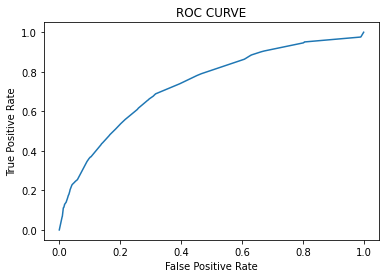

In [66]:
from pyspark.ml.functions import vector_to_array
from sklearn import metrics
import matplotlib.pyplot as plt

y_test = prediction.select("Top-up").rdd.keys().collect()
y_pred_proba = prediction.select(vector_to_array("probability")[1]).rdd.keys().collect()
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.title('ROC CURVE')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [67]:

ExtractFeatureImp(model_gbtc.stages[-1].featureImportances, prediction_gbtc, "features").head(5)

,idx,name,score
6,6,DISBURSED-AMT/HIGH CREDIT_sum,0.141738
7,7,CURRENT-BAL_sum,0.096977
149,149,State_ohe_TELANGANA,0.073116
131,131,ManufacturerID_ohe_1049,0.053102
14,14,MonthlyIncome,0.049545


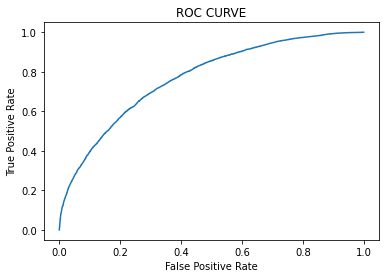

In [68]:
from pyspark.ml.functions import vector_to_array
from sklearn import metrics
import matplotlib.pyplot as plt

y_test = prediction_gbtc.select("Top-up").rdd.keys().collect()
y_pred_proba = prediction_gbtc.select(vector_to_array("probability")[1]).rdd.keys().collect()
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.title('ROC CURVE')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

As we have seen the AUC was higher for Gradient boosted tree, that's why we have chosen it. AUc shows the performance of the classification model at all classification thresholds. More the value better the prediction and better judgement of the data set. It measures how well predictions are ranked rather than its absolute value. It shows how good our model is in distinguishing between classes. Excellent models has AUC close to 1, whereas bad model will have AUC close to 0.

### 2.3.5 
Using the pipeline model you selected in the previous step, re-train the pipeline
model using a bigger set of rebalanced training data, with top-up events and non-top
up events being a 1:2 ratio, while using all top-up events data from the full data. Then
persist the better models for each pipeline model.
    
    ○ The models would be deployed in Part B of assignment 2.
    
    ○ If your module spends too much time or cracks due to limit memory, try to rechoose the columns, As the server provided by MonPG only has limited performance.

In [69]:
top_up_df = trainDF.filter(col("Top-up") == 1).sample(0.6)
non_top_up_df = trainDF.filter(col("Top-up") == 0)


ratio = 0.2

combined_df_3 = top_up_df.unionAll(non_top_up_df.limit(int(top_up_df.count()*2)))
combined_df_3.count()


45441

In [70]:
combined_df_3.groupBy("Top-up").count().show()

+------+-----+
|Top-up|count|
+------+-----+
|     1|15147|
|     0|30294|
+------+-----+



In [71]:
gbt_re_train = pipeline_gbtc.fit(combined_df_3)
gbt_prediction = gbt_re_train.transform(testDF)

In [72]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


AUC = BinaryClassificationEvaluator(labelCol = "Top-up", rawPredictionCol="rawPrediction").evaluate(gbt_prediction)
accuracy = MulticlassClassificationEvaluator(labelCol = "Top-up", predictionCol="prediction", metricName = "accuracy").evaluate(gbt_prediction)
recall = MulticlassClassificationEvaluator(labelCol = "Top-up", predictionCol="prediction", metricName = "weightedRecall").evaluate(gbt_prediction)
precision = MulticlassClassificationEvaluator(labelCol = "Top-up", predictionCol="prediction", metricName = "weightedPrecision").evaluate(gbt_prediction)
print("Gradient Boosted Tree")
print("AUC = %s" % AUC)
print("ACCURACY = %s" % accuracy)
print("RECALL = %s" % recall)
print("PRECISION = %s" % precision)

Gradient Boosted Tree
AUC = 0.77428676958931
ACCURACY = 0.7719217779260309
RECALL = 0.7719217779260309
PRECISION = 0.7534030580634803


In [76]:
# persisting the data
gbt_re_train.save("re-train_pipeline_model_final")

### Knowledge sharing (10%)

In [ ]:
test_df = spark.createDataFrame([[0, 35.3, 37.5],
[1, 41.4, -23.5],
[2, 28.3, -13.3],
[3, 09.5, -9.0],
[4, 62.8, -18.23],
[5, 63.8, -18.33],
[6, 82.8, -17.23],
[7, 52.8, -13.43],
[8, 72.8, 48.23],
[9, 65.8, 15.43],
[10, 42.8, -13.23] ],
["ID","Att_1", "Att_2"])

In [ ]:
from pyspark.ml.clustering import KMeans
assembler = VectorAssembler(
inputCols=["Att_1", "Att_2"],
outputCol='features')
kmeans = KMeans(k=4).fit(assembler.transform(test_df))

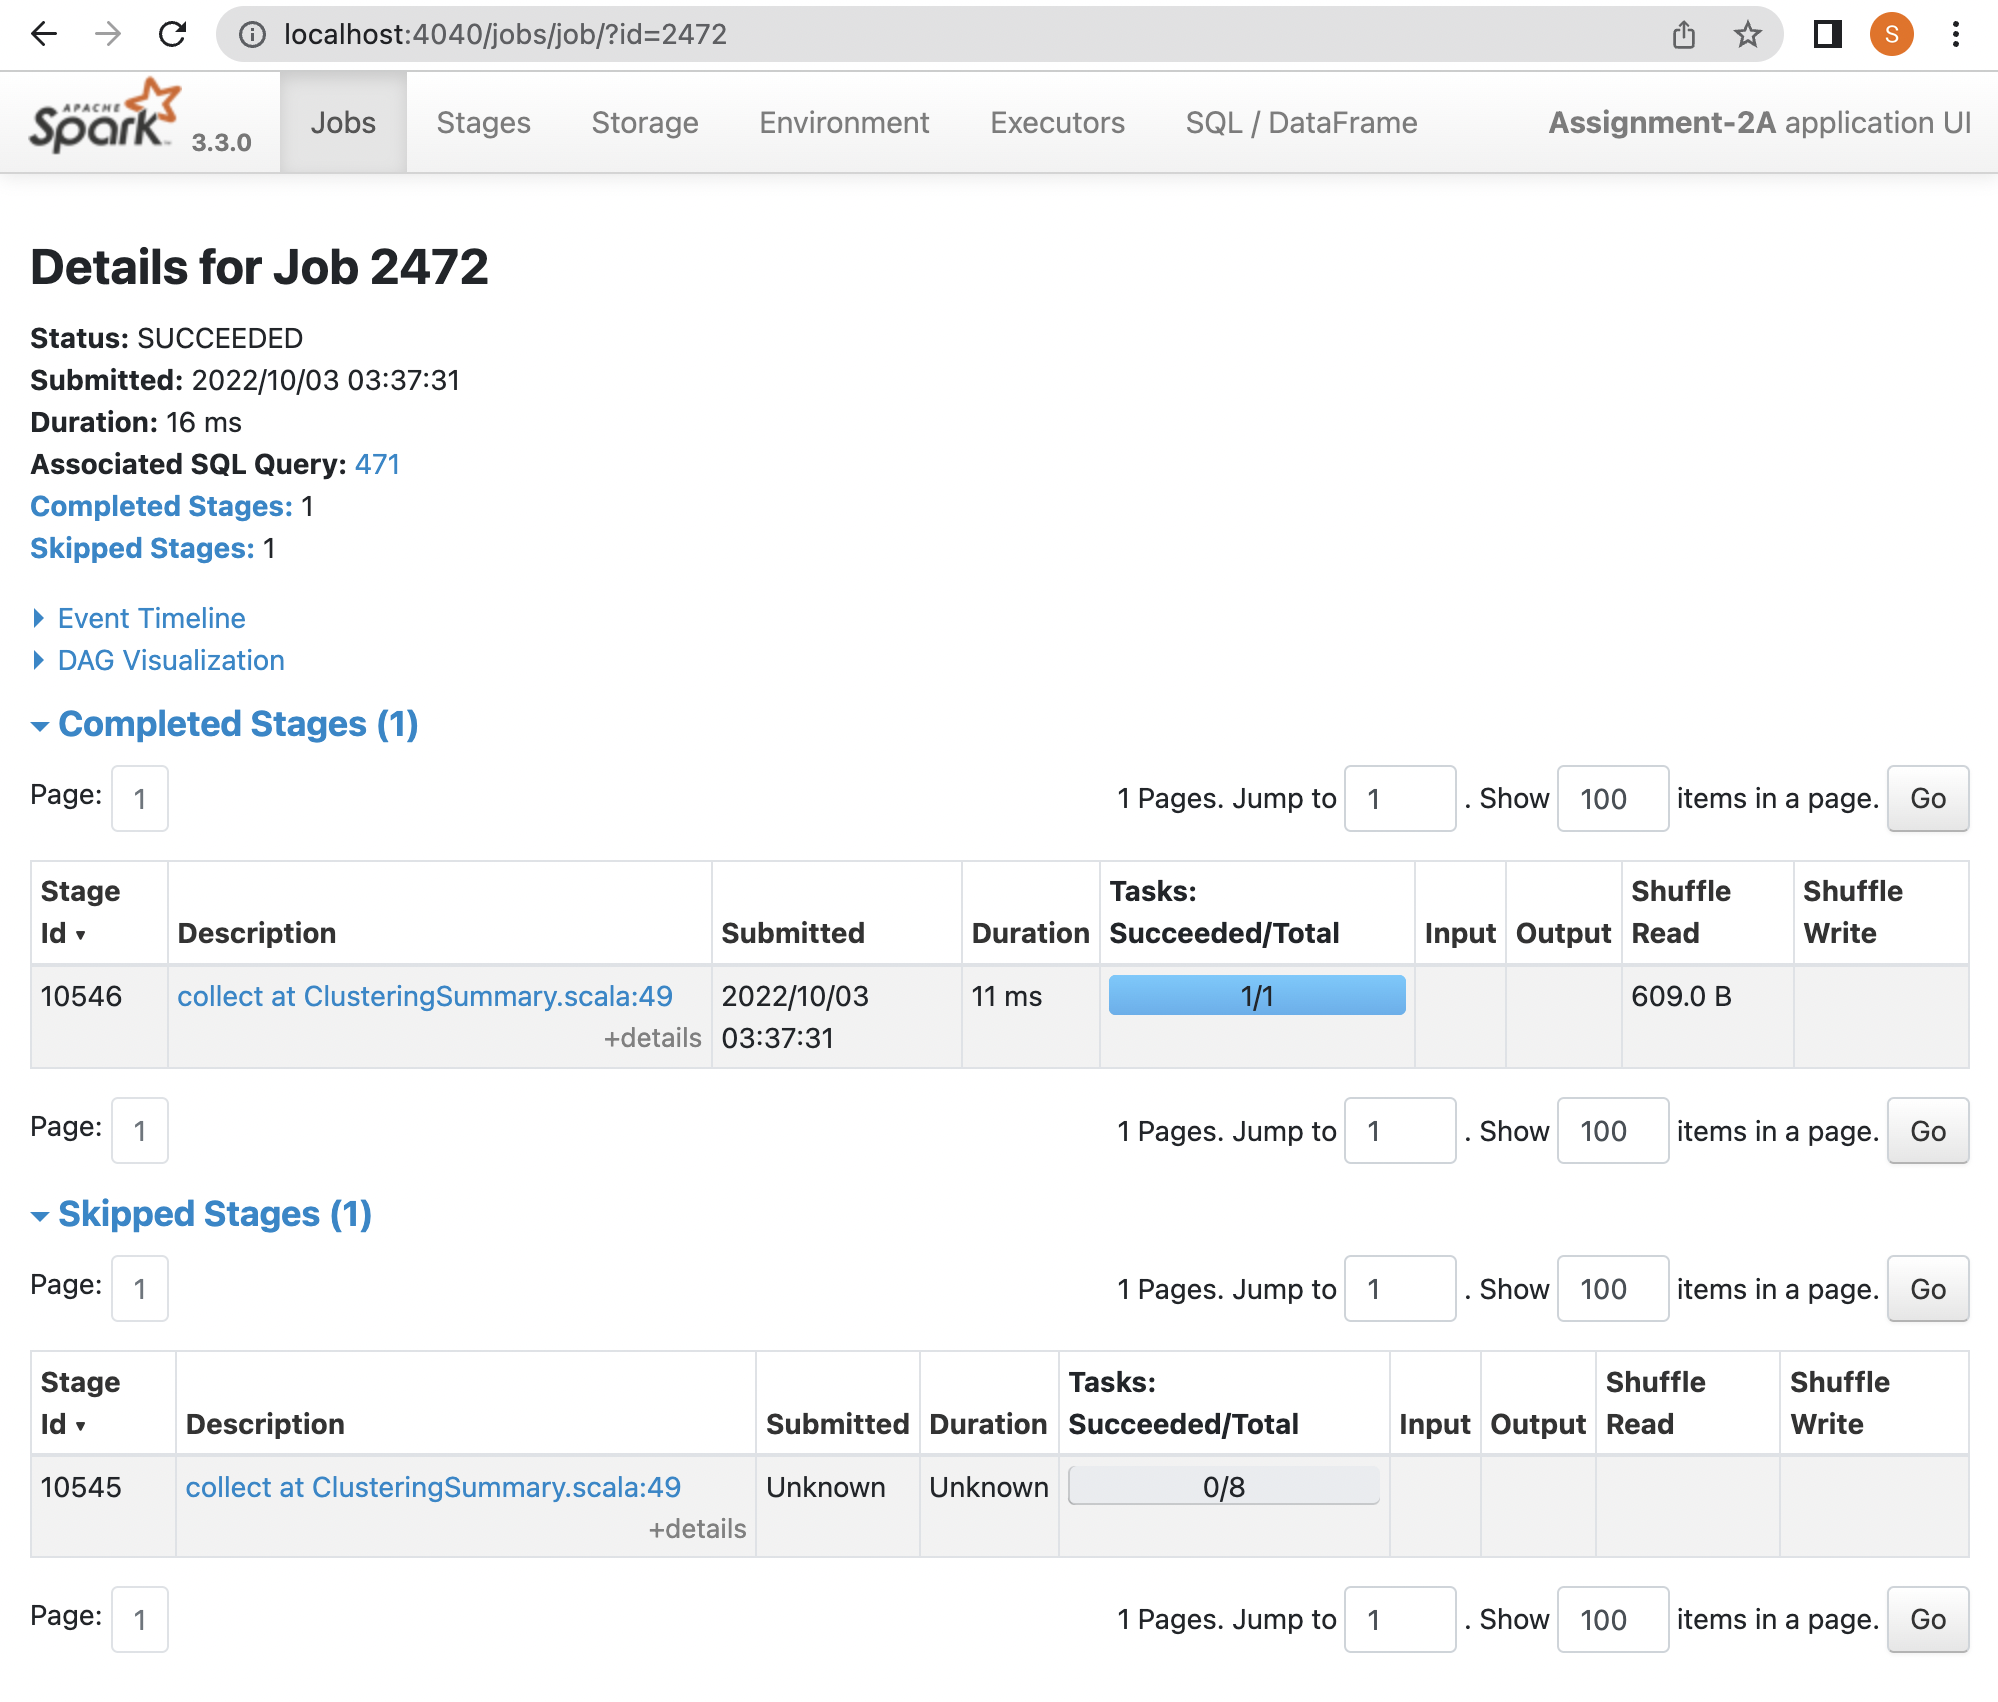

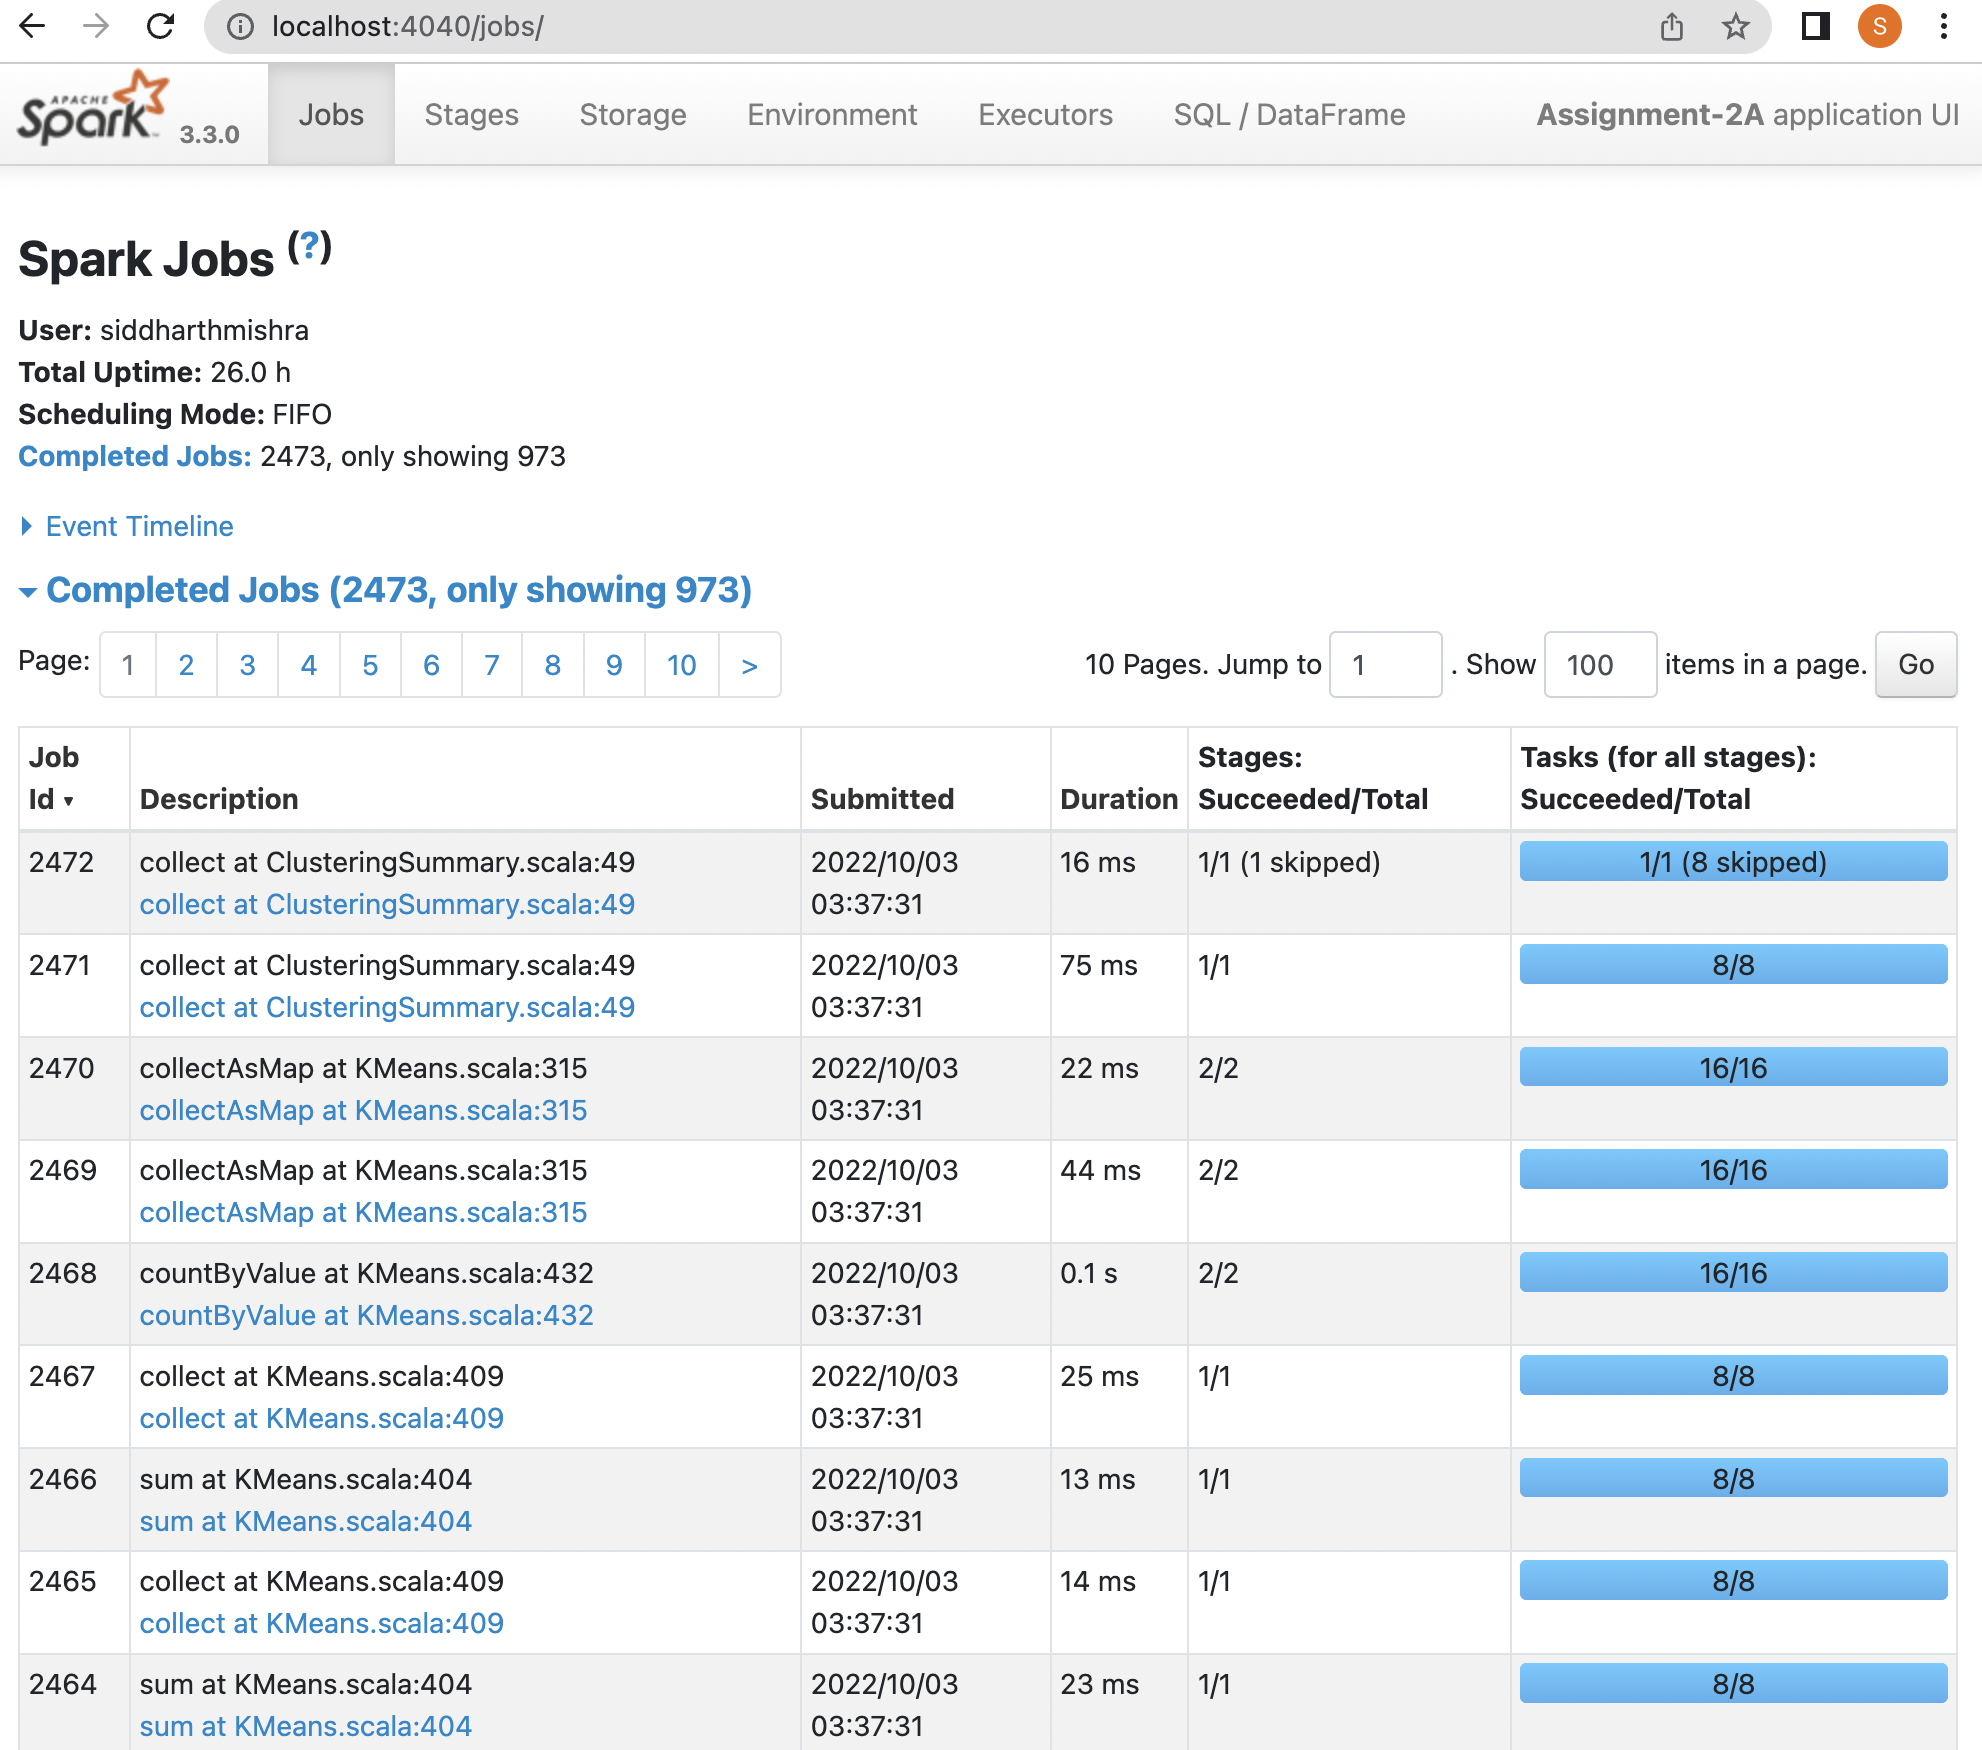

{
        
        // Initial cluster centers can be provided as a KMeansModel object rather than using the
      // random or k-means|| initializationMode
      private var initialModel: Option[KMeansModel] = None

      /**
           * Set the initial starting point, bypassing the random initialization or k-means||
       * The condition model.k == this.k must be met, failure results
       * in an IllegalArgumentException.
       */
      @Since("1.4.0")
      def setInitialModel(model: KMeansModel): this.type = {
        require(model.k == k, "mismatched cluster count")
        initialModel = Some(model)
        this
      }
    }


Clustering is most used data analysis technique.
K-means is an iterative algorithm which tries to divide the dataset into distinct clustering. Unlike supervised learning clustering is considered as unsupersvised learning.
The above mentioned method is used to initialize the and choose the initial center by default in spark. Given kmeans iterative and random initialization of centriod, if it generated a number of centers more than 'k', then it may stuck in a local optimum and may not converge to global optimum. 
The way Kmeans approach to solve the issue is called Expectation maximization. The E-Step is giving  the data point closest cluster. THe M-step is to calculate the centroid of eash cluster. Since clustering algorithmsincluding kmeans use distance based measurement to find the resembelance between data points it is recommended to standardize the data to have a mean of 0 and standard diviation of 1.

### REFERENCES
For correlation plot
https://kanoki.org/2022/01/17/matplotlib-heatmap-for-correlation-matrix-using-dataframe/

For feature importance
https://www.timlrx.com/blog/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator

For Custom transformer
https://csyhuang.github.io/2020/08/01/custom-transformer/

For ROC curve
https://www.statology.org/plot-roc-curve-python/

Other useful links
https://stackoverflow.com/questions/52401043/pyspark-how-to-get-precision-recall-roc-from-trainvalidationsplit


Clustering is most used data analysis technique. K-means is an iterative algorithm which tries to divide the dataset into distinct clustering. The above mentioned method is used to initialize the and choose the initial center by default in spark. Given kmeans iterative and random initialization of centriod, if it generated a number of centers more than 'k', then it may stuck in a local optimum and may not converge to global optimum